# Run sentence embeddings on Perek (2012) stimuli

In [1]:
import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import torch
from collections import defaultdict
import random
import math
import pickle
import sklearn.decomposition
from sentence_transformers import SentenceTransformer

import src.sent_encoder
from src.fisher_metric import fisher_discriminant

%matplotlib inline
%load_ext autoreload
%autoreload 2
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

In [2]:
df = pd.read_csv("../data/perek2012.csv")

In [3]:
enc = src.sent_encoder.SentEncoder()

In [ ]:
sent_vecs = enc.sentence_vecs(df.sentence.tolist())

num_layers = sent_vecs.shape[1]

## PCA plot (dim=2)

In [5]:
layer = 11
pca_model = sklearn.decomposition.PCA(n_components=2, whiten=True)
pca_vecs = pca_model.fit_transform(sent_vecs[:, layer])

In [6]:
pca_vecs.shape

(16, 2)

In [7]:
df['PC1'] = pca_vecs[:, 0]
df['PC2'] = pca_vecs[:, 1]

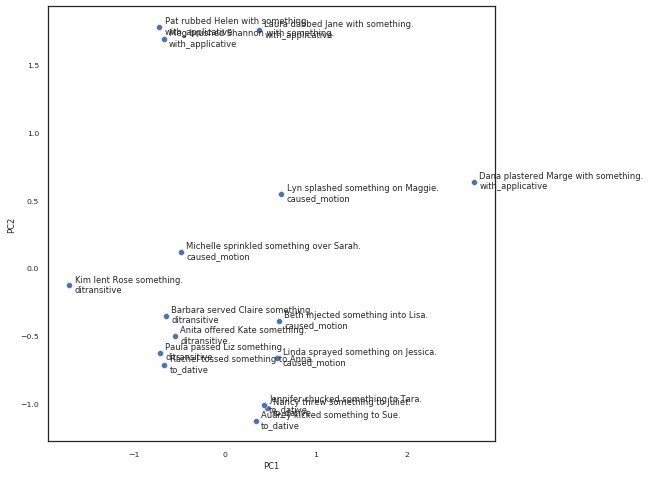

In [8]:
sns.set(rc={'figure.figsize':(8, 8)})
sns.set(font_scale=0.7)
sns.set_style('white')
g = sns.scatterplot(x=df.PC1, y=df.PC2)
for _, row in df.iterrows():
  label_text = f"{row.sentence}\n{row.construction}"
  g.text(row['PC1'] + 0.06, row['PC2'] - 0.05, label_text)
plt.show()

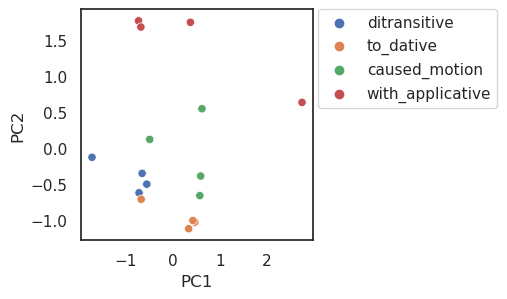

In [9]:
matplotlib.rc_file_defaults()
sns.set(rc={'figure.figsize':(3, 3)})
sns.set_style('white')
sns.scatterplot(x=df.PC1, y=df.PC2, hue=df.construction)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

## Calculate pairwise Fisher discriminant

In [10]:
cxns = df.construction.unique()
results = []
for i1 in range(4):
  for i2 in range(i1+1, 4):
    cxn1 = cxns[i1]
    cxn2 = cxns[i2]
    cxn1_vecs = sent_vecs[df[df.construction == cxn1].index.tolist(), layer]
    cxn2_vecs = sent_vecs[df[df.construction == cxn2].index.tolist(), layer]

    fisher_score = fisher_discriminant(['a'] * 4 + ['b'] * 4, np.vstack([cxn1_vecs, cxn2_vecs]))
    results.append(pd.Series({
      'cxn1': cxn1,
      'cxn2': cxn2,
      'fisher_score': fisher_score,
    }))
    
results = pd.DataFrame(results)

In [11]:
# Smaller Fisher score = semantically closer
results.sort_values('fisher_score')

,cxn1,cxn2,fisher_score
5,caused_motion,with_applicative,0.434090
4,to_dative,with_applicative,0.534357
3,to_dative,caused_motion,0.561624
2,ditransitive,with_applicative,0.722984
0,ditransitive,to_dative,0.831134
1,ditransitive,caused_motion,0.847973
